In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import os
import scipy.ndimage as nd
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as sk
from utils import utils
plt.style.use('ggplot')
from sklearn import metrics

In [3]:
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data
import torch
import PIL.ImageOps
import skimage
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

In [4]:
available_device = "cuda" if torch.cuda.is_available() else "cpu"

#### Load dataset

In [5]:
transformations = [tfs.RandomAffine(0., scale=(0.5, 1.), fillcolor=0),
                   tfs.Resize((128, 128)),
                   #tfs.Grayscale(1),
                   tfs.Lambda(lambda x: PIL.ImageOps.invert(x))]

imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose(transformations))

data_loader = data.DataLoader(imagenet_data, batch_size=4, shuffle=False)

In [6]:
print(len(imagenet_data))

6812


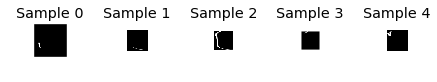

In [7]:
fig = plt.figure()

for i in range(len(imagenet_data)):
    sample = imagenet_data[i + 10]
    #print(sample)
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    plt.imshow(np.asarray(sample[0]), cmap=plt.cm.gray_r)
    ax.set_title('Sample {}'.format(i))
    ax.axis('off')

    if i == 4:
        plt.show()
        break

#### Process type of vessels for classification

In [8]:
df = utils.create_df_from_files(path='data/perfiles_CATA/clases/')

#### Build and train classifier

In [9]:
imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose([tfs.RandomHorizontalFlip(p=0.7),
                                                           tfs.RandomAffine(0, scale=(0.7, 1.), fillcolor=0),
                                                           tfs.Resize((128, 128)),
                                                           tfs.ToTensor()]))
                                                           

In [10]:
splits_len = round(len(imagenet_data.samples)*0.2), round(len(imagenet_data.samples)*0.1), round(len(imagenet_data.samples)*0.7)

In [11]:
splits_len = splits_len if np.sum(splits_len) == len(imagenet_data.samples) else splits_len[0]-1, splits_len[1], splits_len[2] +2

#### Split

In [12]:
np.sum(splits_len)

6812

In [13]:
#All
splits = utils.random_split(imagenet_data, splits_len)
print(splits_len)

(1361, 681, 4770)


In [14]:
"""
import pickle
file_pi2 = open('data_pickle/indice_0.pickle', 'rb') 
splits[0].indices = pickle.load(file_pi2)
print(len(splits[0].indices))

file_pi2 = open('data_pickle/indice_1.pickle', 'rb') 
splits[2].indices = pickle.load(file_pi2)
print(len(splits[2].indices))
"""

"\nimport pickle\nfile_pi2 = open('data_pickle/indice_0.pickle', 'rb') \nsplits[0].indices = pickle.load(file_pi2)\nprint(len(splits[0].indices))\n\nfile_pi2 = open('data_pickle/indice_1.pickle', 'rb') \nsplits[2].indices = pickle.load(file_pi2)\nprint(len(splits[2].indices))\n"

In [15]:
train_loader = data.DataLoader(splits[2], batch_size=32, shuffle=False)
test_loader = data.DataLoader(splits[0], batch_size=32, shuffle=False)

In [16]:
import torch.optim as optim
from torch import nn
from models.classifierResnet import _C
import visdom
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import TopKCategoricalAccuracy, Loss
from ignite.handlers import ModelCheckpoint
import torch.nn.functional as F

In [17]:
C =_C(input_h_w=128)
C = C.to(available_device)

In [18]:
checkpoint = torch.load("models/frac_checkpoint_data_resnet/frac_cnn_vessels_model_254.pth")
C.load_state_dict(checkpoint)

In [19]:
y_real_test, X_test = utils.iterations_test_partial(C, test_loader, available_device)
y_real_train, X_train = utils.iterations_test_partial(C, train_loader, available_device)

In [20]:
files_train = np.array(imagenet_data.imgs)[train_loader.dataset.indices][:, 0]

# UMAP

<Figure size 1296x864 with 0 Axes>

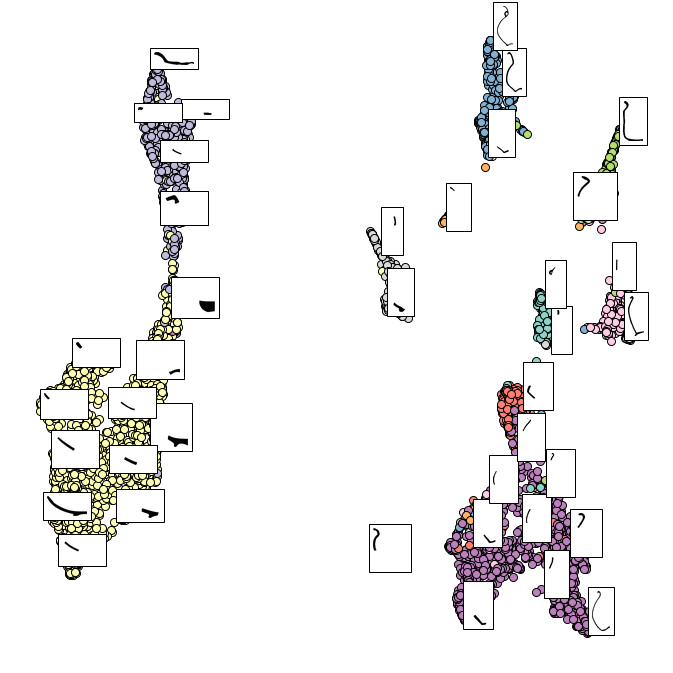

In [21]:
import umap
plt.rcParams['figure.figsize'] = [9.0*2, 6.0*2]
merged_train = pd.DataFrame(np.concatenate(( np.expand_dims(files_train, 1), np.expand_dims(y_real_train, 1)), axis=1))
fit = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        metric='euclidean',
        random_state=17
    )
u = fit.fit_transform(X_train);
fig = plt.figure()
#ax = fig.add_subplot(111)
utils.plot_embedding(u[:,[0,1]], merged_train, "", 11)
#ax.scatter(u[:,0], u[:,1], c=c)
plt.gca().set_aspect('equal')
#plt.savefig("result_plot/resNet/unap_resnet.png", dpi=300, bbox_inches='tight')
plt.show()

# SVM

In [22]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_real_train)
y_pred_test = clf.predict(X_test)

Normalized confusion matrix


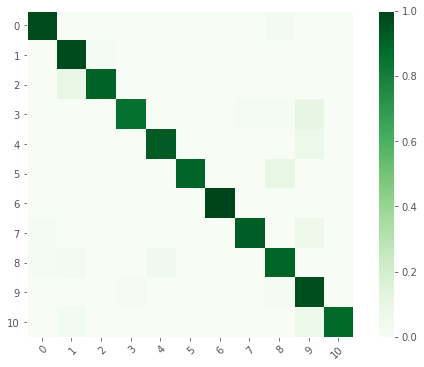

In [23]:
plt.rcParams['figure.figsize'] = [9.0, 6.0]
utils.plot_confusion_matrix(y_real_test, y_pred_test, list(range(10)), "result_plot/test_1.png", normalize=True)

# RandomForestClassifier

In [24]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500,max_depth=4)
clf.fit(X_train, y_real_train)
y_pred_test = clf.predict(X_test)

Normalized confusion matrix


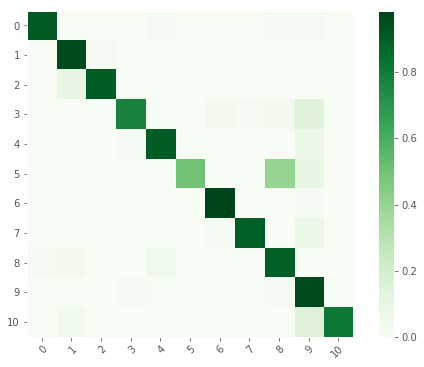

In [25]:
plt.rcParams['figure.figsize'] = [9.0, 6.0]
utils.plot_confusion_matrix(y_real_test, y_pred_test, list(range(10)), "result_plot/test.png", normalize=True)

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import make_scorer

In [27]:
X_train, y_real_train = np.array(X_train), np.array(y_real_train)
X_test, y_real_test = np.array(X_test), np.array(y_real_test)

In [28]:
import skimage

In [29]:
X_train.shape

(4770, 512)

In [30]:
merged_train.shape

(4770, 2)

In [31]:
merged_train.iloc[10]

0    data/perfiles_CATA/png_clasificados/10/LP9_3_f...
1                                                    1
Name: 10, dtype: object

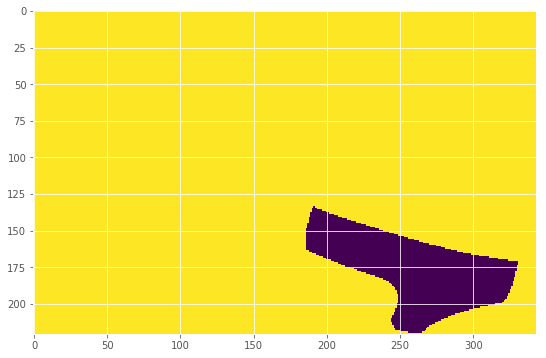

In [33]:
plt.imshow(skimage.io.imread(merged_train.iloc[10][0], 0))

In [34]:
import scipy

In [35]:
dist = []
for j,i in enumerate(X_train):
    a = scipy.spatial.distance.euclidean(i, X_train[10])
    if a == 0:
        dist.append(100000000)
    else:
        dist.append(a)

In [36]:
merged_train.iloc[np.argmin(dist)]

0    data/perfiles_CATA/png_clasificados/10/AT030_f...
1                                                    1
Name: 2429, dtype: object

In [37]:
merged_train.iloc[10]

0    data/perfiles_CATA/png_clasificados/10/LP9_3_f...
1                                                    1
Name: 10, dtype: object

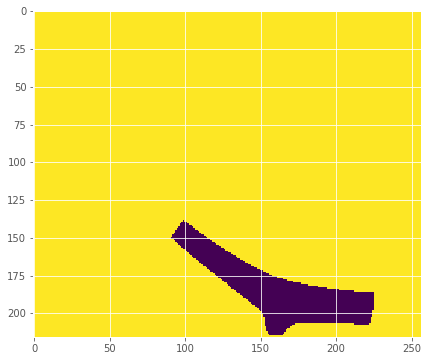

In [38]:
plt.imshow(skimage.io.imread(merged_train.iloc[np.argmin(dist)][0], 0))

In [39]:
merged_train.iloc[np.argmin(dist)][0], merged_train.iloc[10][0]

('data/perfiles_CATA/png_clasificados/10/AT030_frac_3.png',
 'data/perfiles_CATA/png_clasificados/10/LP9_3_frac_3.png')

In [40]:
imgA = merged_train.iloc[10][0].replace("_frac_0", "").replace("_frac_1", "").replace("_frac_2", "").replace("_frac_3", "").replace("_frac_4", "").replace("_frac_5", "")
imgB = merged_train.iloc[np.argmin(dist)][0].replace("_frac_0", "").replace("_frac_1", "").replace("_frac_2", "").replace("_frac_3", "").replace("_frac_4", "").replace("_frac_5", "")

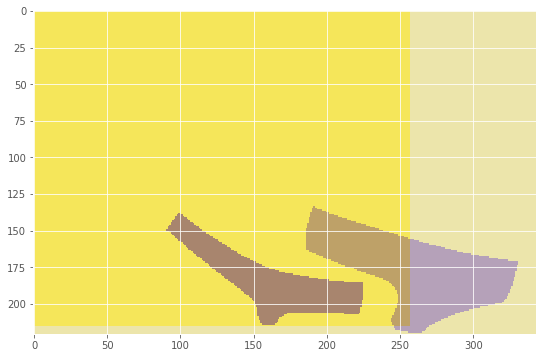

In [43]:
fig, ax = plt.subplots()
#ax.imshow(skimage.io.imread(imgB, 0), alpha=0.6)

ax.imshow(skimage.io.imread(merged_train.iloc[np.argmin(dist)][0], 0), alpha=0.6)
ax.imshow(skimage.io.imread(merged_train.iloc[10][0], 0), alpha=0.3)

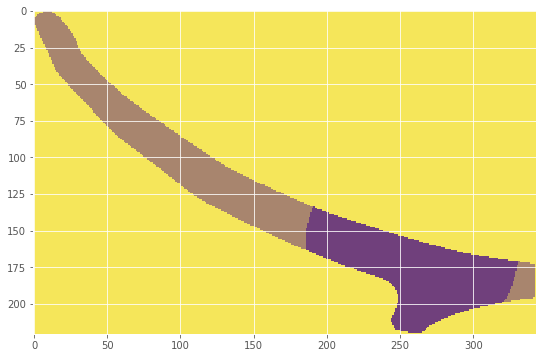

In [44]:
fig, ax = plt.subplots()
#ax.imshow(skimage.io.imread(imgB, 0), alpha=0.6)

ax.imshow(skimage.io.imread(imgA, 0 ), alpha=0.6)
ax.imshow(skimage.io.imread(merged_train.iloc[10][0], 0), alpha=0.3)

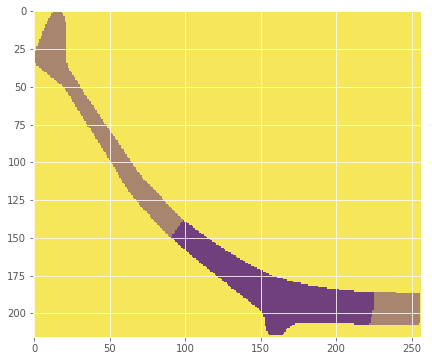

In [45]:
fig, ax = plt.subplots()
#ax.imshow(skimage.io.imread(imgB, 0), alpha=0.6)

ax.imshow(skimage.io.imread(imgB, 0 ), alpha=0.6)
ax.imshow(skimage.io.imread(merged_train.iloc[np.argmin(dist)][0], 0), alpha=0.3)